# Categorical Feature Encoding:

## Introduction:

In most data science problems, our datasets will contain categorical features. Categorical features contain a finite number of discrete values. How we represent these features will have an impact on the performance of our model. Like in other aspects of machine learning, there are no silver bullets. Determining the correct approach, specific to our model and data is part of the challenge.

This tutorial aims to cover a few of these methods. We begin by covering a straight-forward technique before tackling more complicated lesser-known approaches.

**List of methods covered**:
1. One-Hot Encoding
2. Feature Hashing
3. Binary Encoding
4. Target Encoding
5. Weight of Evidence

In [1]:
# Import required libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Set our random seed:
SEED = 17
PATH_TO_DIR = '../input/amazoncom-employee-access-challenge/'

print(os.listdir(PATH_TO_DIR))

['train.csv', 'sampleSubmission.csv', 'test.csv']


For this tutorial, we will be using the '[Amazon.com Employee Access Challenge](https://www.kaggle.com/c/amazon-employee-access-challenge)' dataset. This binary classification dataset is made up of strictly categorical features, which are already converted into numerals, making it a particularly suitable choice to explore various encoding techniques. To simplify things we will only be using a subset of the features for this demonstration.

In [2]:
# Import data:
train = pd.read_csv(PATH_TO_DIR + 'train.csv')

In [3]:
y = train['ACTION']
train = train[['RESOURCE', 'MGR_ID', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']]

We will compare differences of these encoding methods on both a linear model and tree-based model. These represent two families of models which have contrasting behaviours when it comes to different feature representations.

In [4]:
logit = LogisticRegression(random_state=SEED)
rf = RandomForestClassifier(random_state=SEED)

In [5]:
# Split dataset into train and validation subsets:
X_train, X_val, y_train, y_val = train_test_split(train, y, test_size=0.2, random_state=SEED)

In [6]:
# We create a helper function to get the scores for each encoding method:
def get_score(model, X, y, X_val, y_val):
    model.fit(X, y)
    y_pred = model.predict_proba(X_val)[:,1]
    score = roc_auc_score(y_val, y_pred)
    return score

In [7]:
# Lets have a quick look at our data:
X_train.head(5)

,RESOURCE,MGR_ID,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
22434,29071,5178,158101,118424,118828
24163,20222,5550,119235,292795,118997
10066,79092,6047,279443,308574,118779
19869,14570,51104,189996,19721,118570
1855,32642,18097,130662,292795,117948


In [8]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26215 entries, 22434 to 10863
Data columns (total 5 columns):
RESOURCE            26215 non-null int64
MGR_ID              26215 non-null int64
ROLE_FAMILY_DESC    26215 non-null int64
ROLE_FAMILY         26215 non-null int64
ROLE_CODE           26215 non-null int64
dtypes: int64(5)
memory usage: 1.2 MB


In [9]:
# Discover the number of categories within each categorical feature:
len(X_train.RESOURCE.unique()), len(X_train.MGR_ID.unique()), len(X_train.ROLE_FAMILY_DESC.unique()), len(X_train.ROLE_FAMILY.unique()),len(X_train.ROLE_CODE.unique())

(6711, 4062, 2201, 67, 337)

In [10]:
# Create a list of each categorical column name:
columns = [i for i in X_train.columns]

Before getting started, lets have a look at the speed and performance of training these models without any feature encoding.

In [11]:
%%time
baseline_logit_score = get_score(logit, X_train, y_train, X_val, y_val)
print('Logistic Regression score without feature engineering:', baseline_logit_score)

Logistic Regression score without feature engineering: 0.5350998573215817
CPU times: user 72 ms, sys: 36 ms, total: 108 ms
Wall time: 86.1 ms


In [12]:
%%time
baseline_rf_score = get_score(rf, X_train, y_train, X_val, y_val)
print('Random Forest score without feature engineering:', baseline_rf_score)

Random Forest score without feature engineering: 0.7785989401031782
CPU times: user 512 ms, sys: 172 ms, total: 684 ms
Wall time: 489 ms


## One-Hot Encoding:

The first method we will be covering is one that no doubt will be familiar to you. One-hot encoding expands a categorical feature made up of m categories into m* distinct features with values of either 0 or 1.

There are two ways of implementing one-hot encoding, either with pandas or scikit-learn. In this tutorial we have chosen to use the latter.

*Actually, it is seen as more correct to expand m categories into (m - 1) distinct features. The reason for this is twofold. Firstly, if the values of (m - 1) features are known, the m-th feature can be inferred and secondly because including the m-th feature can cause certain linear models to become unstable. More on that can be found [here](https://www.algosome.com/articles/dummy-variable-trap-regression.html). In practice I think this depends on your model. Some non-linear models actually do better with m features.

In [13]:
from sklearn.preprocessing import OneHotEncoder

one_hot_enc = OneHotEncoder(sparse=False)

In [14]:
print('Original number of features: \n', X_train.shape[1], "\n")
data_ohe_train = (one_hot_enc.fit_transform(X_train))
data_ohe_val = (one_hot_enc.transform(X_val))
print('Features after OHE: \n', data_ohe_train.shape[1])

Original number of features: 
 5 

Features after OHE: 
 13378


In [15]:
%%time
ohe_logit_score = get_score(logit, data_ohe_train, y_train, data_ohe_val, y_val)
print('Logistic Regression score with one-hot encoding:', ohe_logit_score)

Logistic Regression score with one-hot encoding: 0.8658376997849282
CPU times: user 1.12 s, sys: 404 ms, total: 1.52 s
Wall time: 1.47 s


In [16]:
%%time
ohe_rf_score = get_score(rf, data_ohe_train, y_train, data_ohe_val, y_val)
print('Random Forest score with one-hot encoding:', ohe_rf_score)

Random Forest score with one-hot encoding: 0.8151528170201999
CPU times: user 3min 58s, sys: 4.14 s, total: 4min 2s
Wall time: 4min 2s


As we can see, while the performance of the model has improved, training took longer as well. This is due to the increase in the number of features. Computational costs are not the only problem associated with the increase in dimensions. A dataset with more features will require a model with more parameters which in turn will require more data to train these parameters. In many cases, such as kaggle competitions, the size of our data is fixed and as a result the dimensionality of our data should always be a concern.

One way of dealing with high dimensionality is by compressing the features. Feature hashing, which we will be covering next, is an example of this.

## Feature Hashing:

Feature hashing maps each category in a categorical feature to an integer within a pre-determined range. This output range is smaller than the input range so multiple categories may be mapped to the same integer. Feature hashing is very similar to one-hot encoding but with a control over the output dimensions.

To implement feature hashing in python we can use category_encoder, a library containing sklearn compabitable category encoders.

In [17]:
# Install category_encoders:
# pip install category_encoders

In [18]:
from category_encoders import HashingEncoder

The size of the output dimensions is controlled by the variable n_components. This can be treated as a hyperparameter.

In [19]:
n_components_list = [100, 500, 1000, 5000, 10000]
n_components_list_str = [str(i) for i in n_components_list]

In [20]:
fh_logit_scores = []

# Iterate over different n_components:
for n_components in n_components_list:
    
    hashing_enc = HashingEncoder(cols=columns, n_components=n_components).fit(X_train, y_train)
    
    X_train_hashing = hashing_enc.transform(X_train.reset_index(drop=True))
    X_val_hashing = hashing_enc.transform(X_val.reset_index(drop=True))
    
    fe_logit_score = get_score(logit, X_train_hashing, y_train, X_val_hashing, y_val)
    fh_logit_scores.append(fe_logit_score)

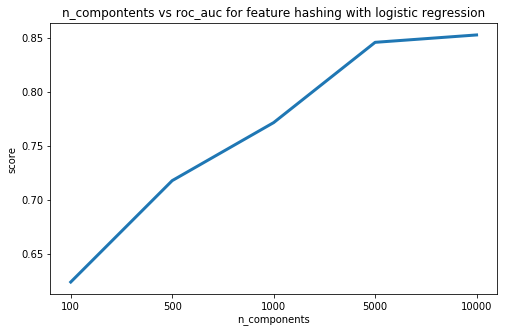

In [21]:
plt.figure(figsize=(8, 5))
plt.plot(n_components_list_str, fh_logit_scores, linewidth=3)
plt.title('n_compontents vs roc_auc for feature hashing with logistic regression')
plt.xlabel('n_components')
plt.ylabel('score')
plt.show;

As we can see, performance on the Logistic Regression model improves as the number of components increase. But let us have a look at the effect of reducing the dimensions has on a Random Forest model.

In [22]:
hashing_enc = HashingEncoder(cols=columns, n_components=10000).fit(X_train, y_train)

X_train_hashing = hashing_enc.transform(X_train.reset_index(drop=True))
X_val_hashing = hashing_enc.transform(X_val.reset_index(drop=True))

In [23]:
X_train_hashing.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19,col_20,col_21,col_22,col_23,col_24,col_25,col_26,col_27,col_28,col_29,col_30,col_31,col_32,col_33,col_34,col_35,col_36,col_37,col_38,col_39,...,col_9960,col_9961,col_9962,col_9963,col_9964,col_9965,col_9966,col_9967,col_9968,col_9969,col_9970,col_9971,col_9972,col_9973,col_9974,col_9975,col_9976,col_9977,col_9978,col_9979,col_9980,col_9981,col_9982,col_9983,col_9984,col_9985,col_9986,col_9987,col_9988,col_9989,col_9990,col_9991,col_9992,col_9993,col_9994,col_9995,col_9996,col_9997,col_9998,col_9999
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [24]:
%%time
hashing_logit_score = get_score(logit, X_train_hashing, y_train, X_val_hashing, y_val)
print('Logistic Regression score with feature hashing:', hashing_logit_score)

Logistic Regression score with feature hashing: 0.8526684993463501
CPU times: user 8.37 s, sys: 12 ms, total: 8.38 s
Wall time: 8.31 s


In [25]:
%%time
hashing_rf_score = get_score(rf, X_train_hashing, y_train, X_val_hashing, y_val)
print('Random Forest score with feature hashing:', hashing_rf_score)

Random Forest score with feature hashing: 0.82298563375926
CPU times: user 27.3 s, sys: 268 ms, total: 27.5 s
Wall time: 27.2 s


It improves! As we may have guessed, reducing the number of features improves the performance of tree-based models. 

## Binary Encoding:

Binary encoding involves converting each category into a binary code, for example 2 becomes 11 and 3 becomes 100, and then splitting the resulting binary string into columns. 

This may be easier to understand with an example:

In [26]:
# Create example dataframe with numbers ranging from 1 to 5:
example_df = pd.DataFrame([1,2,3,4,5], columns=['example'])

from category_encoders import BinaryEncoder

example_binary = BinaryEncoder(cols=['example']).fit_transform(example_df)

example_binary

,example_0,example_1,example_2,example_3
0,0,0,0,1
1,0,0,1,0
2,0,0,1,1
3,0,1,0,0
4,0,1,0,1


Binary encoding is clearly very similar to feature hashing however much more restricted. In practice using feature hashing is often advised over binary encoding due to the control you have over the output dimensions.

In [27]:
binary_enc = BinaryEncoder(cols=columns).fit(X_train, y_train)

In [28]:
X_train_binary = binary_enc.transform(X_train.reset_index(drop=True))
X_val_binary = binary_enc.transform(X_val.reset_index(drop=True))
# note: category_encoders implementations can't handle shuffled datasets. 

In [29]:
print('Features after Binary Encoding: \n', X_train_binary.shape[1])

Features after Binary Encoding: 
 58


In [30]:
%%time
be_logit_score = get_score(logit, X_train_binary, y_train, X_val_binary, y_val)
print('Logistic Regression score with binary encoding:', be_logit_score)

Logistic Regression score with binary encoding: 0.6410124457048876
CPU times: user 308 ms, sys: 12 ms, total: 320 ms
Wall time: 302 ms


In [31]:
%%time
binary_rf_score = get_score(rf, X_train_binary, y_train, X_val_binary, y_val)
print('Random Forest score with binary encoding:', binary_rf_score)

Random Forest score with binary encoding: 0.7455560153361729
CPU times: user 432 ms, sys: 248 ms, total: 680 ms
Wall time: 390 ms


## Target Encoding:

Target encoding is the first of our Bayesian encoders. These are a family of encoders which take information about the target variable into account. Target encoding may refer to an encoder which considers the statistical correlation between the individual categories of a categorical feature. In this tutorial we will only look at target encoders which focus on the relationship between each category and the mean of the target as this is the most commonly used variation of target encoding.

In [32]:
from category_encoders import TargetEncoder

targ_enc = TargetEncoder(cols=columns, smoothing=8, min_samples_leaf=5).fit(X_train, y_train)

In [33]:
X_train_te = targ_enc.transform(X_train.reset_index(drop=True))
X_val_te = targ_enc.transform(X_val.reset_index(drop=True))

In [34]:
X_train_te.head()

,RESOURCE,MGR_ID,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,0.941675,0.972658,0.996885,0.971549,0.993056
1,0.749391,0.828075,0.758443,0.864438,0.777108
2,0.966019,0.991365,0.923077,0.946237,0.910714
3,0.897076,0.977980,0.967211,0.910612,0.931873
4,0.818242,0.570837,0.570837,0.864438,0.851711


In [35]:
%%time
te_logit_score = get_score(logit, X_train_te, y_train, X_val_te, y_val)
print('Logistic Regression score with target encoding:', te_logit_score)

Logistic Regression score with target encoding: 0.8369910052854271
CPU times: user 84 ms, sys: 12 ms, total: 96 ms
Wall time: 82 ms


In [36]:
%%time
te_rf_score = get_score(rf, X_train_te, y_train, X_val_te, y_val)
print('Random Forest score with target encoding:', te_rf_score)

Random Forest score with target encoding: 0.767684128958799
CPU times: user 292 ms, sys: 272 ms, total: 564 ms
Wall time: 267 ms


As a result of using the target variable, data-leakage and overfitting is a huge concern. The category_encoders implementation has two out of the box ways of regularizing the encodings, 'smoothing' and 'min_samples_leaf'. These parameters may be treated as hyperparameters.

'smoothing' determines the weighting of the individual category's mean with the mean of the entire categorical variable. This is to prevent the influence of unreliable means from categories with low sample sizes.

'min_samples_leaf' is the minimum number of samples within a category to take it's mean into account.

In [37]:
targ_enc = TargetEncoder(cols=columns, smoothing=8, min_samples_leaf=5).fit(X_train, y_train)

X_train_te = targ_enc.transform(X_train.reset_index(drop=True))
X_val_te = targ_enc.transform(X_val.reset_index(drop=True))

In [38]:
%%time
me_logit_score = get_score(logit, X_train_te, y_train, X_val_te, y_val)
print('Logistic Regression score with target encoding with regularization:', me_logit_score)

Logistic Regression score with target encoding with regularization: 0.8369910052854271
CPU times: user 80 ms, sys: 12 ms, total: 92 ms
Wall time: 78.3 ms


In [39]:
%%time
me_rf_score = get_score(rf, X_train_te, y_train, X_val_te, y_val)
print('Random Forest score with target encoding with regularization:', me_rf_score)

Random Forest score with target encoding with regularization: 0.767684128958799
CPU times: user 328 ms, sys: 240 ms, total: 568 ms
Wall time: 266 ms


Another approach to regularizing the target encoder is to calculate the statistic relationship between each category and the target variable via a kfold split. This method is currently not available in category_encoders implementation and needs to be written from scratch.

In [40]:
from sklearn.model_selection import KFold

# Create 5 kfold splits:
kf = KFold(random_state=17, n_splits=5, shuffle=False)

In [41]:
# Create copy of data:
X_train_te = X_train.copy()
X_train_te['target'] = y_train

In [42]:
all_set = []

for train_index, val_index in kf.split(X_train_te):
    # Create splits:
    train, val = X_train_te.iloc[train_index], X_train_te.iloc[val_index]
    val=val.copy()
    
    # Calculate the mean of each column:
    means_list = []
    for col in columns:
        means_list.append(train.groupby(str(col)).target.mean())
    
    # Calculate the mean of each category in each column:
    col_means = []
    for means_series in means_list:
        col_means.append(means_series.mean())
    
    # Encode the data:
    for column, means_series, means in zip(columns, means_list, col_means):
        val[str(column) + '_target_enc'] = val[str(column)].map(means_series).fillna(means) 
    
    list_of_mean_enc = [str(column) + '_target_enc' for column in columns]
    list_of_mean_enc.extend(columns)
    
    all_set.append(val[list_of_mean_enc].copy())

X_train_te=pd.concat(all_set, axis=0)

In [43]:
# Apply encodings to validation set:
X_val_te = pd.DataFrame(index=X_val.index)
for column, means in zip(columns, col_means):
    enc_dict = X_train_te.groupby(column).mean().to_dict()[str(column) + '_target_enc']
    X_val_te[column] = X_val[column].map(enc_dict).fillna(means)

In [44]:
# Create list of target encoded columns:
list_of_target_enc = [str(column) + '_target_enc' for column in columns]

In [45]:
%%time
kf_reg_logit_score = get_score(logit, X_train_te[list_of_target_enc], y_train, X_val_te, y_val)
print('Logistic Regression score with kfold-regularized target encoding:', kf_reg_logit_score)

Logistic Regression score with kfold-regularized target encoding: 0.8433289493105047
CPU times: user 88 ms, sys: 8 ms, total: 96 ms
Wall time: 84.7 ms


In [46]:
%%time
kf_reg_rf_score = get_score(rf, X_train_te[list_of_target_enc], y_train, X_val_te, y_val)
print('Random Forest score with kfold-regularized target encoding:', kf_reg_rf_score)

Random Forest score with kfold-regularized target encoding: 0.7747987215170301
CPU times: user 412 ms, sys: 240 ms, total: 652 ms
Wall time: 356 ms


## Weight Of Evidence (WOE):

Weight of evidence (WOE) encoder calculates the natural log of the % of non-events divided by the % of events for each category within a categotical feature. For clarification, the events are referring to the target variable. 

In [47]:
from category_encoders import WOEEncoder

woe_enc = WOEEncoder(cols=columns, random_state=17).fit(X_train, y_train)

In [48]:
X_train_woe = woe_enc.transform(X_train.reset_index(drop=True))
X_val_woe = woe_enc.transform(X_val.reset_index(drop=True))

In [49]:
X_train_woe.head()

,RESOURCE,MGR_ID,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,0.000000,-0.834486,0.586900,0.734514,1.496270
1,-1.799567,-1.933098,-1.835935,-0.933496,-1.550448
2,0.500515,0.215336,-0.317557,0.070517,-0.480253
3,-0.732703,-0.477811,-1.394102,-0.464076,-0.180961
4,-1.338012,-3.696687,-3.696687,-0.933496,-1.053175


In [50]:
%%time
woe_logit_score = get_score(logit, X_train_woe, y_train, X_val_woe, y_val)
print('Logistic Regression score with woe encoding:', woe_logit_score)

Logistic Regression score with woe encoding: 0.7973584285694204
CPU times: user 76 ms, sys: 16 ms, total: 92 ms
Wall time: 76 ms


In [51]:
%%time
woe_rf_score = get_score(rf, X_train_woe, y_train, X_val_woe, y_val)
print('Random Forest score with woe encoding:', woe_rf_score)

Random Forest score with woe encoding: 0.7700949022336552
CPU times: user 404 ms, sys: 244 ms, total: 648 ms
Wall time: 348 ms


In summary, categorical features may be represented in more ways than the traditional one-hot encoding. These representations have different effects on our models and the choice of representation is task specific. Feature hashing and binary encoding offer us ways of encoding the data with lower dimensions which is cheaper computationally as well as being better suited for tree-based models. Target encoding and weight of evidence encoding seem to be much more task specific. 

Feedback would be appreciated, as well as upvotes! Thank you.

### Further Reading:

* [category_encoder documentation](http://contrib.scikit-learn.org/categorical-encoding/)
* [weight of evidence](https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html)
* [smarter ways of encoding categorical data for machine learning](https://towardsdatascience.com/smarter-ways-to-encode-categorical-data-for-machine-learning-part-1-of-3-6dca2f71b159)
* [an exploration of categorical variables](http://www.willmcginnis.com/2015/11/29/beyond-one-hot-an-exploration-of-categorical-variables/)